In [1]:
import numpy as np
import scipy.stats as st
from scripts.BA_C import BA
import math
import random as rand
import matplotlib.pyplot as plt
import pandas as pd
import os, sys

In [2]:
"""Parameters to compute the output of the deterministic integration channel. 
Leakiness, 0<l<1, which determines the rate of leaky transcription in the absence of the environmental input, X.
Frequency parameter, alpha>0, which determines the rate at which operator (O) switches between 0 and 1 states.

k_m = Transcription rate constant
k_dm = Transcript decay rate constant

k_dgs = Set of protein decay rate constant, which determines the range of integration times, T = k_dm/k_dg.

HX = Input code length in bits.
X = 2^HX uniformly spaced values of the input in the domain [0,1].
"""

l = 0.01
alpha = 1.0

k_m = 0.5
k_dm = 0.5

k_dgs = [0.5,0.2,0.1,0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002]

tag = str(int(k_m/k_dm))

T = np.array([k_dm/k for k in k_dgs])

HX = 6
X = np.linspace(0,1.0,int(2**HX))

# Replicates
reps = 1

In [3]:
"""Compute parameters for the transcript expression distribution as shown in,
So, L. H., Ghosh, A., Zong, C., Sepúlveda, L. A., Segev, R., & Golding, I. (2011). General properties of transcriptional time series in Escherichia coli. Nature genetics, 43(6), 554-560.

Rate constants for operator activity/inactivity:
k_on = alpha[(1-l)X + l], which ranges for l to 1, when X changes from 0 to 1.
k_off = alpha(1-l)(1-X), which changes from 1-l to 0, when X changes from 0 to 1.

Using k_on, k_off, k_m, and k_dm, we compute the parameters for the Negative Binomial distribution, 
r = number of failures
p = the probability of success 
"""

r_params = np.zeros(shape=(X.shape[0],2))

for i in range(0,X.shape[0]):
    k_on = alpha*((1-l)*X[i] + l)
    k_off = alpha*(1 - X[i])*(1 - l)
    
    m = (k_m/k_dm)*k_on/(k_on + k_off)
    
    b = 1 + (k_dm*k_off*m)/(k_on*(k_on+k_off+k_dm)) 
    
    beta = b - 1
    
    if beta>0.0:
        r_params[i,0] = m/beta
        r_params[i,1] = (b - 1.0)/b
    else:
        r_params[i,0] = m
        r_params[i,1] = 0.0

In [4]:
bao = BA()

bin_size = 100

n_samples = 1000000

all_cs = np.zeros(shape=(T.shape[0],1+reps))

all_cs[:,0] = T

In [5]:
for rr in range(0,reps):
    for it in range(0,T.shape[0]):
        t = T[it]
        
        # create bins
        if r_params[0,1]>0.0:
            g_min = st.nbinom.ppf(0.01,r_params[0,0]*t,1-r_params[0,1])
        else:
            g_min = st.poisson.ppf(0.01,r_params[0,0]*t)

        if r_params[-1,1]>0.0:
            g_max = st.nbinom.ppf(0.99,r_params[-1,0]*t,1-r_params[-1,1])
        else:
            g_max = st.poisson.ppf(0.99,r_params[-1,0]*t)
        
        bin_size = min(200,g_max - g_min + 1)
    
        g_bin_edges = np.linspace(g_min,g_max+1,bin_size+1)
        g_locs_i = g_bin_edges.astype(int)
        g_pdfs = np.zeros(shape=(r_params.shape[0],g_locs_i.shape[0]))

        for i in range(0,r_params.shape[0]):
            if r_params[i,1]>0.0:
                p = r_params[i,1]
                r = r_params[i,0]*t

                l_cdf = st.nbinom.cdf(g_locs_i,r,1-p,0)
                #l_pdf = l_cdf
                #l_pdf[1:] = l_pdf[1:] - l_pdf[:-1]
            else:
                r = r_params[i,0]*t
                g_samples = st.poisson.rvs(r,0,n_samples)
                
                l_cdf = st.poisson.cdf(g_locs_i,r,0)
                    
            l_pdf = l_cdf
            l_pdf[1:] = l_pdf[1:] - l_pdf[:-1]
                
            g_pdfs[i,:] = l_pdf/np.sum(l_pdf)


        bao.set_response(g_pdfs)
        c_g, e, p = bao.get_CC()

        all_cs[it,0] = t
        all_cs[it,rr+1] = c_g

print(all_cs[:,1])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


[0.402963   0.73411555 0.93078326 1.18374076 1.57671177 1.92386251
 2.30718623 2.85503964 3.29337085 3.7443304  4.33840378]


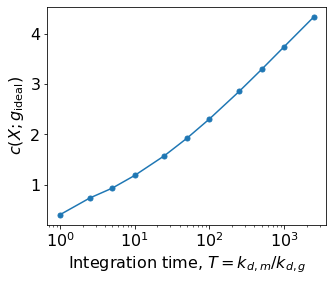

In [7]:
fig = plt.figure(figsize=(5,4))

plt.plot(all_cs[:,0],all_cs[:,1],marker='.',ms=10)
plt.xscale('log')
plt.xlabel(r'Integration time, $T=k_{d,m}/k_{d,g}$',size=16)
plt.ylabel(r'$c(X;g_{\mathrm{ideal}})$',size=16)
plt.tick_params(labelsize=16)